In [1]:
import pandas as pd
import numpy as np 
import uuid

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df0 = pd.read_excel('HW_customers_transactions.xlsx', sheet_name='transaction')
df_customer = pd.read_excel('HW_customers_transactions.xlsx', sheet_name='customer')

In [4]:
df_customer.loc[df_customer['gender'].isin(['F', 'Femal']), 'gender'] = 'Female'
df_customer.loc[df_customer['gender'] == 'M', 'gender'] = 'Male'

In [5]:
df_customer['address_code'] = df_customer.address.apply(lambda x: x.split(' ')[0])
df_customer['address_name'] = df_customer.address.apply(lambda x: ' '.join(x.split(' ')[1:]))

In [6]:
df_customer = df_customer.drop(columns='address')

In [7]:
df_product = df0[['product_id','brand','product_line','product_class','product_size']]

In [8]:
df_product = df_product.drop_duplicates() 

In [9]:
df_product['product_uid'] = df_product['product_id'].apply(lambda x: uuid.uuid4())

In [10]:
df0 = df0.merge(df_product, how='left', on=['product_id','brand','product_line','product_class','product_size'])

In [11]:
df_transaction = df0[['transaction_id','product_uid','customer_id','transaction_date','online_order','order_status','list_price', 'standard_cost']]

In [12]:
df_product = df_product.replace({np.nan: None})
df_transaction = df_transaction.replace({np.nan: None})
df_customer = df_customer.replace({np.nan: None})

In [13]:
df_transaction['product_uid']=df_transaction['product_uid'].astype(str)
df_product['product_uid']=df_product['product_uid'].astype(str)

In [15]:
# Ключ (customer_id)=(5034) отсутствует в таблице "customer"
df_empty = pd.DataFrame(data={'customer_id':[5034], 'first_name':[None], 'last_name':[None], 'gender':[None], 'DOB':[None], 'job_title':[None],
       'job_industry_category':[None], 'wealth_segment':[None], 'deceased_indicator':[None], 'owns_car':[None],
        'address_code':[None], 'address_name':[None], 'postcode':[None], 'state':[None], 'country':[None], 'property_valuation':[None]})
df_customer = pd.concat([df_customer, df_empty])

In [19]:
import psycopg2 

import psycopg2.extras as extras 
import pandas as pd 


def execute_values(conn, df, table): 
    tuples = [tuple(x) for x in df.to_numpy()] 
    cols = ','.join(list(df.columns)) 
    query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols) 
    cursor = conn.cursor() 
    try: 
        extras.execute_values(cursor, query, tuples) 
        conn.commit() 
        return True
    except (Exception, psycopg2.DatabaseError) as error: 
        print("Ошибка: %s" % error) 
        conn.rollback() 
        return False
    finally:
        cursor.close() 


conn = psycopg2.connect( 
	database="postgres", user='postgres', password='arsen', host='127.0.0.1', port='5433'
) 

In [20]:
execute_values(conn, df_customer, 'module1.customer') 

True

In [21]:
execute_values(conn, df_product, 'module1.product') 

True

In [22]:
execute_values(conn, df_transaction, 'module1.transaction') 

True

# Выделим три таблицы: customer, product, transaction
Для преведения их к 3НФ сделаем следующие шаги:
1) все таблицы не содержат составных данных в ячейках/столбцах
2) таблица customer не содержит дубликатов, содержит уникальный первичный ключ customer_id, при этом в колонке gender таблицы customers есть неуникальные названия - переименуем. Так же разделим поле address на поля address_code и address_name
3) таблица product содержит дубликаты, product_id не является уникальным, уникальным является сочетание всех столбцов - удалим дубликаты и введем уникальный product_uid
4) таблица transaction не содержит дубликатов, содержит уникальный первичный ключ transaction_id, + добавляем product_uid, оставляем customer_id
5) таблица customer не содержит (customer_id)=(5034) поэтому добавим customer_id с пустыми полями в таблицу 

Теперь таблицы находятся в 3НФ: 1НФ - атрибуты простые, скалярные, нет дублей в записях, 2НФ - 1НФ + каждый не ключевой атрибут неприводимо зависит от первичного ключа (составе потенциального ключа отсутствует меньшее подмножество атрибутов), 3НФ - 2НФ +  каждый не ключевой атрибут нетранзитивно зависит от первичного ключа (все не ключевые поля, содержимое которых может относиться к нескольким записям таблицы вынесены в отдельные таблицы).



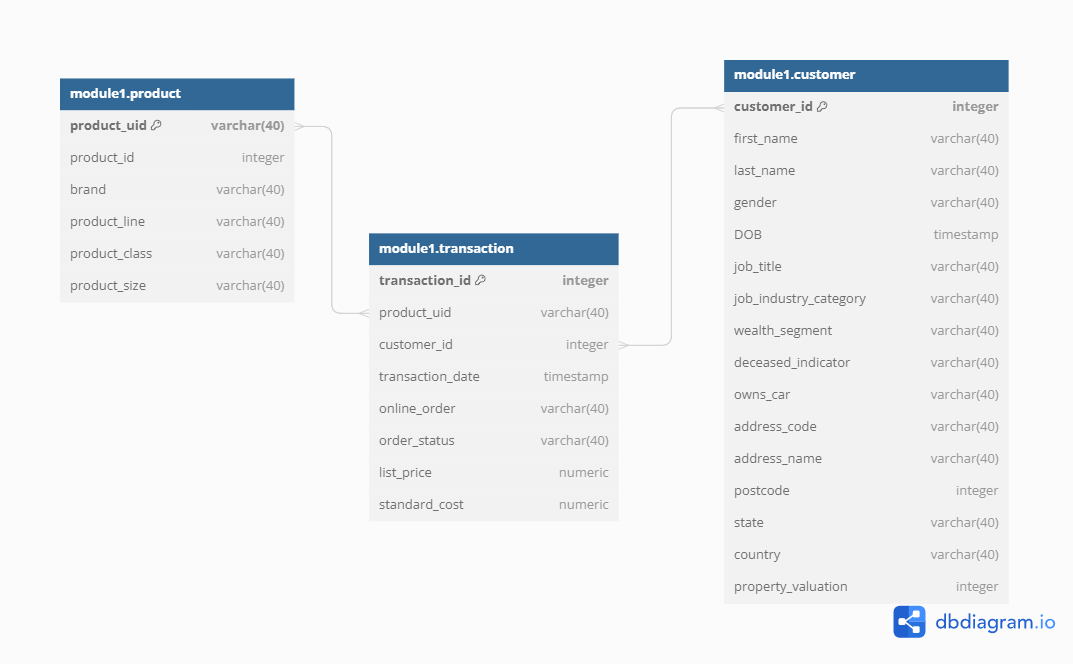

# Создание базы данных в PostgreSQL при помощи DBeaver

CREATE SCHEMA module1;
<br>

<br>
CREATE table module1.product(<br>
product_uid varchar(40) PRIMARY KEY,<br>
product_id integer NOT NULL,<br>
brand varchar(40) NULL,<br>
product_line varchar(40) NULL,<br>
product_class varchar(40) NULL,<br>
product_size varchar(40) NULL<br>
);<br>
<br>
CREATE table module1.customer(<br>
customer_id integer PRIMARY KEY,<br>
first_name varchar(40) NULL,<br>
last_name varchar(40) NULL,<br>
gender varchar(40) NULL,<br>
DOB timestamp NULL,<br>
job_title varchar(40) NULL,<br>
job_industry_category varchar(40) NULL,<br>
wealth_segment varchar(40) NULL,<br>
deceased_indicator varchar(40) NULL,<br>
owns_car varchar(40) NULL,<br>
address_code varchar(40) NULL,<br>
address_name varchar(40) NULL,<br>
postcode integer NULL,<br>
state varchar(40) NULL,<br>
country varchar(40) NULL,<br>
property_valuation integer NULL<br>
);<br>
<br>
CREATE table module1.transaction(<br>
transaction_id integer PRIMARY KEY,<br>
product_uid varchar(40) NULL,<br>
customer_id integer NULL,<br>
transaction_date timestamp NOT NULL,<br>
online_order varchar(40) NULL,<br>
order_status varchar(40) NOT NULL,<br>
list_price numeric NOT NULL,<br>
standard_cost numeric NULL,<br>
FOREIGN KEY(product_uid) REFERENCES module1.product(product_uid),<br>
FOREIGN KEY(customer_id) REFERENCES module1.customer(customer_id)<br>
);<br>

# Загруженные данные в Postgres

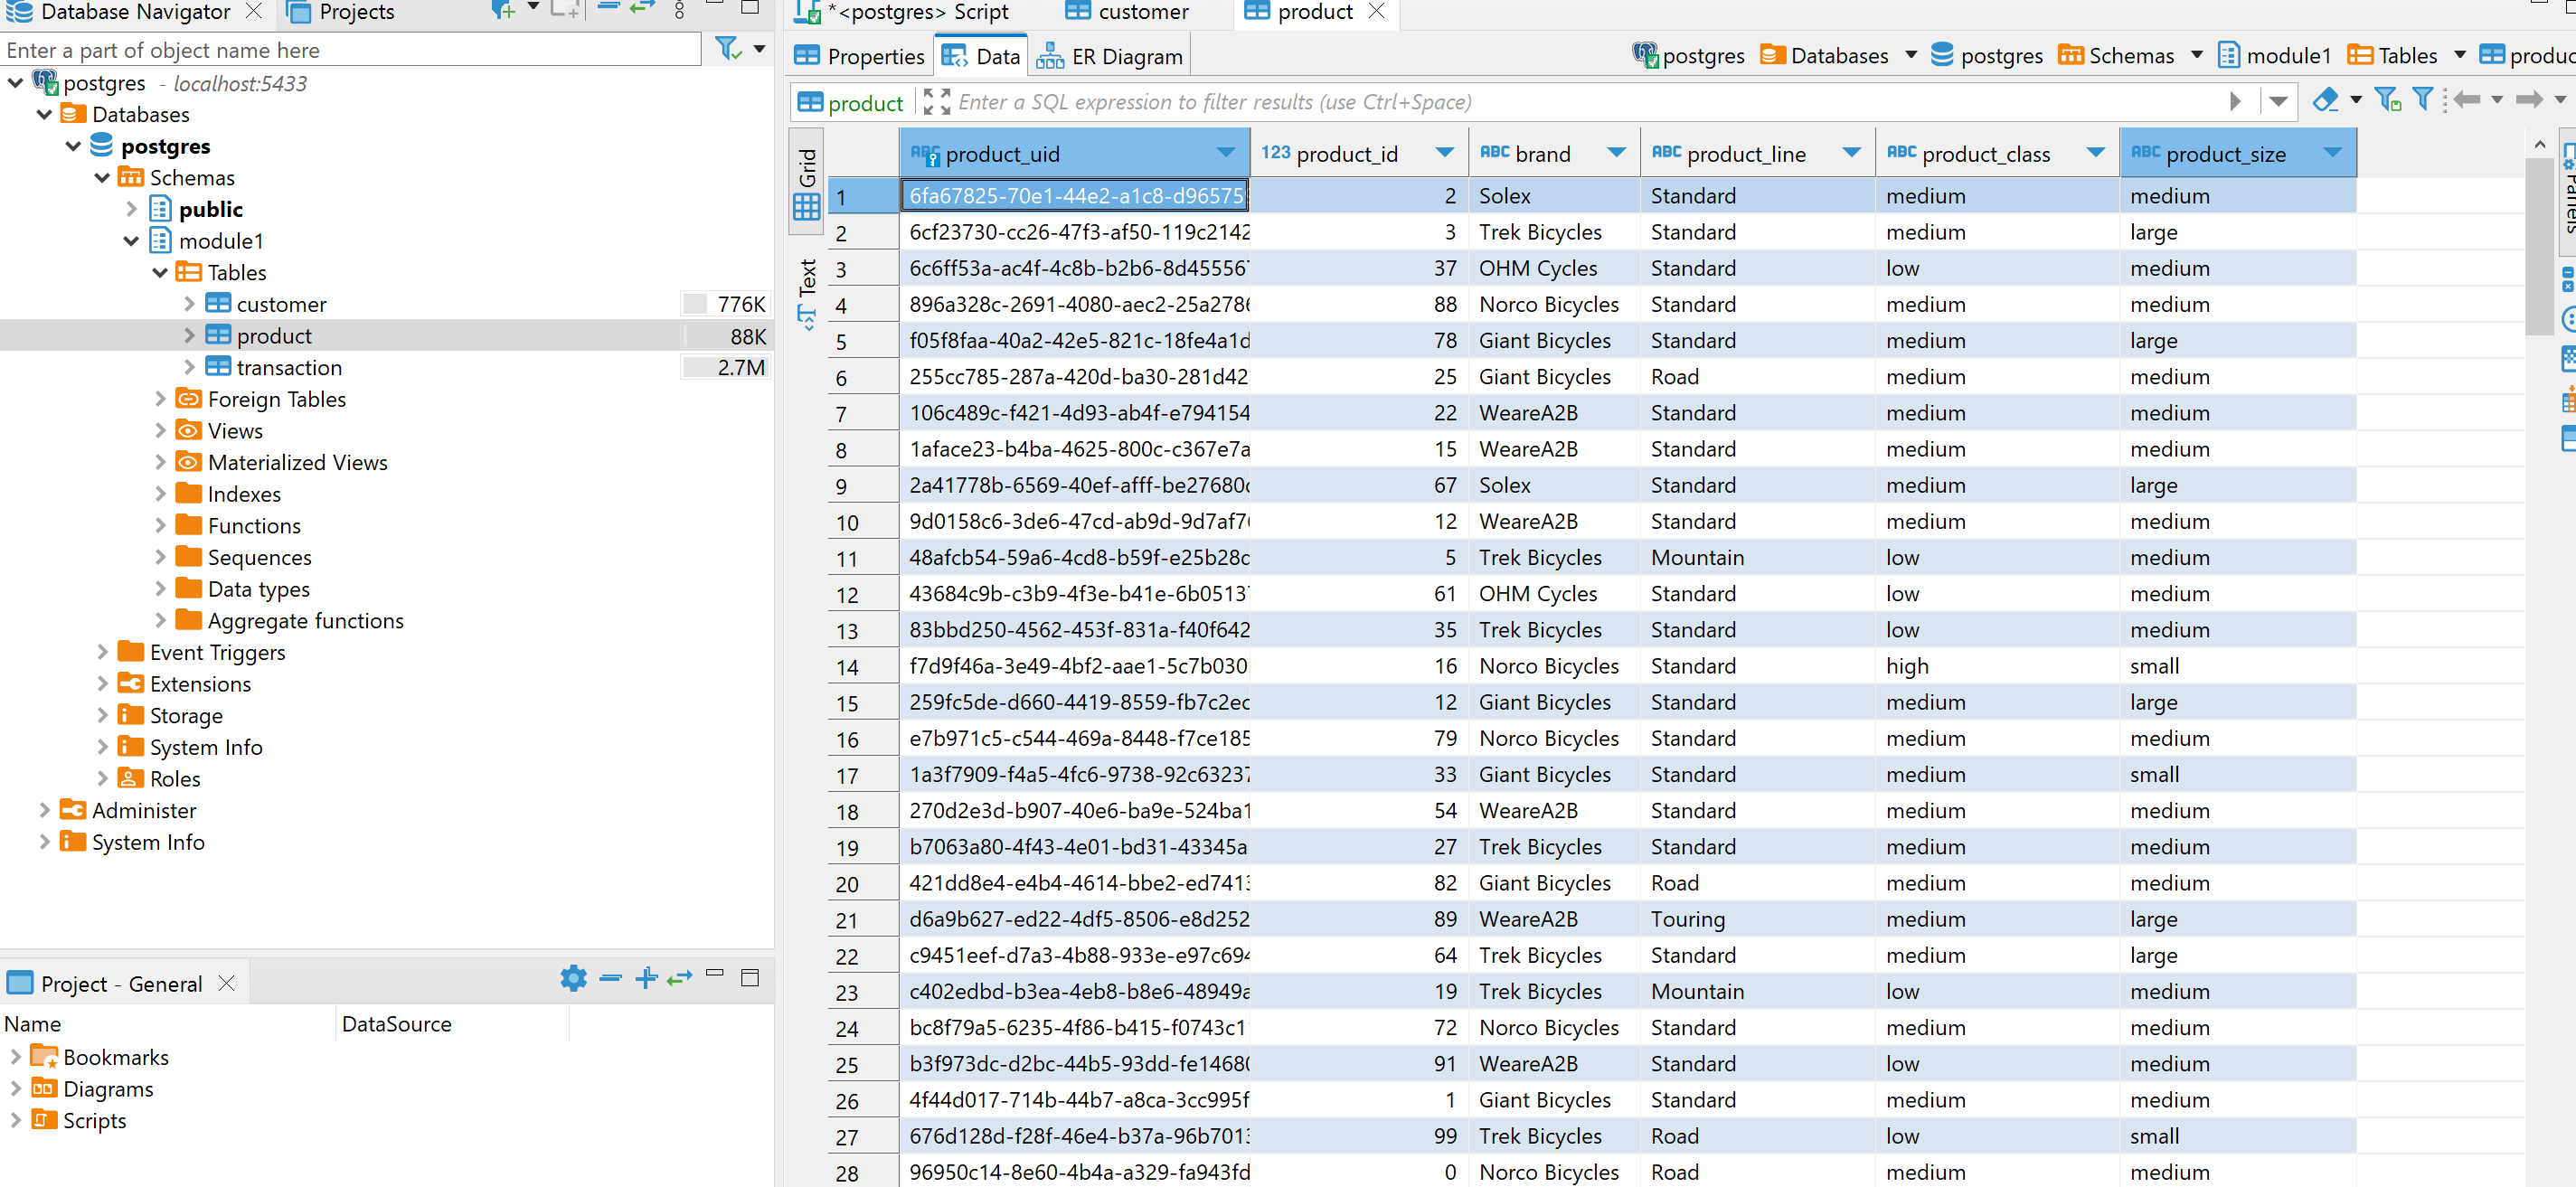